# Load dataset

In [1]:
labels = ['AF', 'N']

In [2]:
import os
# disable GPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

dataset_folder = 'dataset/'
filenames = []
for filename in os.listdir(dataset_folder):
    if filename.find("_all_") > -1 :
        filenames.append(filename)

In [3]:
filenames

['test_all_Conv_AE.csv', 'train_all_Conv_AE.csv']

In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [5]:
train_df = pd.read_csv(dataset_folder + "train_all_Conv_AE.csv", header=None)

test_df = pd.read_csv(dataset_folder + "test_all_Conv_AE.csv", header=None)

## Dataset AFDB
Dataset AFDB terdiri dari 301 kolom, dimana kolom ke 301 merupakan katerori/class.

In [6]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,0.974954,0.690758,0.042791,0.038134,0.380477,0.451081,0.524653,0.546891,0.550161,0.574880,...,0.000149,0.000137,0.000099,0.000087,0.000107,0.000017,0.000108,0.000512,0.000468,0.0
1,0.872333,0.765284,0.529938,0.233678,0.020938,0.022597,0.132292,0.227633,0.295253,0.337568,...,0.000067,0.000047,0.000048,0.000029,0.000028,0.000005,0.000044,0.000265,0.000226,0.0
2,0.793911,0.498961,0.235878,0.050084,0.024675,0.019210,0.028728,0.079710,0.168008,0.335377,...,0.000042,0.000029,0.000021,0.000018,0.000023,0.000003,0.000036,0.000231,0.000163,0.0
3,0.977019,0.755939,0.287272,0.021519,0.019941,0.041552,0.086367,0.214120,0.322379,0.450610,...,0.000053,0.000045,0.000031,0.000032,0.000043,0.000006,0.000053,0.000300,0.000239,0.0
4,0.968693,0.775908,0.424144,0.167343,0.077983,0.094230,0.128767,0.264248,0.378351,0.452329,...,0.000114,0.000153,0.000123,0.000117,0.000154,0.000027,0.000154,0.000711,0.000660,0.0


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29640 entries, 0 to 29639
Columns: 301 entries, 0 to 300
dtypes: float64(301)
memory usage: 68.1 MB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11630 entries, 0 to 11629
Columns: 301 entries, 0 to 300
dtypes: float64(301)
memory usage: 26.7 MB


## Dataset Augmentation

In [9]:
ecg_df = pd.concat([train_df, test_df])

In [10]:
ecg_df[300]=ecg_df[300].astype(int)
equilibre=ecg_df[300].value_counts()

print(equilibre)

1    22614
0    18656
Name: 300, dtype: int64


In [11]:
# sampling and resampling dataset

from sklearn.utils import resample
n_samples = 30000 
random_states = [123, 124]

dfs = []

for i in range(len(equilibre)):
    dfs.append(ecg_df[ecg_df[300]==i])
    dfs[i]=resample(dfs[i],replace=True,n_samples=n_samples,random_state=random_states[i])

ecg_df=pd.concat(dfs)

In [12]:
ecg_df[300]=ecg_df[300].astype(int)
equilibre=ecg_df[300].value_counts()

print(equilibre)

1    30000
0    30000
Name: 300, dtype: int64


- split dataset

In [13]:
target_train = ecg_df[300]
y = to_categorical(target_train)

X = ecg_df.iloc[:,:300].values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, test_size=0.15, random_state=42)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51000, 300), (9000, 300), (51000, 2), (9000, 2))

## 1. Classification Convolutional Neural Network (CNN)

- Import Keras library

In [16]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout, Activation
from keras.layers import Input
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import keras

- Buat CNN Model dengan aritektur network : 
`CONV-POOL-CONV-POOL-CONV-POOL-FC`
- CONV : 1D Convolutional Layer
- POOL : MAX Pooling Layer
- FC   : Dense Layer + Activation

In [15]:
def cnn_model(max_len):
    
    model = Sequential()
    
    model.add(Conv1D(filters=64,
                     kernel_size=5,
                     activation='relu',
                     input_shape=(max_len, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2,
                        strides=2,
                        padding='same'))
    
    
    model.add(Conv1D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2,
                        strides=2,
                        padding='same'))
    
    
    model.add(Conv1D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2,
                        strides=2,
                        padding='same'))
    
    
    # Fully Connected layer (FC)
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(128, 
                    activation='relu'))
    model.add(Dense(32, 
                    activation='relu'))
    model.add(Dense(2, 
                    activation='softmax'))
              
    model.summary()
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

- sekarang kita akan melakukan proses training model dengan memanfaatkan `.fit()` pada model yang kita buat diatas.
- selain itu kita gunakan juka teknik `EarlyStoping()` untuk menghentikan proses training jika terjadi divergensi pada validation data yang diakibatkan oleh overfitting. 
- pada `EarlyStoping()` kita gunakan parmeter `patience=3` yang artinya jika proses training untuk 3 epoch tidak terjadi peningkatan maka hentikan proses training.

In [16]:
def check_model(model_, x, y, x_val, y_val, epochs_, batch_size_):
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
                 ModelCheckpoint(filepath='cnn_best_model.h5', monitor='val_loss', save_best_only=True)]

    hist = model_.fit(x, 
                      y,
                      epochs=epochs_,
                      callbacks=callbacks, 
                      batch_size=batch_size_,
                      shuffle=True,
                      validation_data=(x_val,y_val))
                      #validation_split=0.15)
    #model_.load_weights('cnn_best_model.h5')
    return hist 

### Train Model CNN

- jalankan proses training dengan `EPOCH` sebanyak 16 dan `BATCH_SIZE` sebesar 32

In [17]:
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [192]:
max_len = X_train.shape[1]  

EPOCHS = 16
BATCH_SIZE = 128

model = cnn_model(max_len)
history=check_model(model, X_train,y_train,X_test,y_test, EPOCHS, BATCH_SIZE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 296, 64)           384       
_________________________________________________________________
batch_normalization_1 (Batch (None, 296, 64)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 148, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 146, 64)           12352     
_________________________________________________________________
batch_normalization_2 (Batch (None, 146, 64)           256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 73, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 71, 64)            12352     
__________

- Save model

In [193]:
model.save("CNN_Classification_model.h5")

- save model training history (log)

In [194]:
pd.DataFrame.from_dict(history.history).to_csv('history_train_classif_cnn.csv',index=False)

# Evaluate Model

- Plot Accuracy vs Epochs
- Plot Loss vs Epochs
- Plot Confusion Matrix

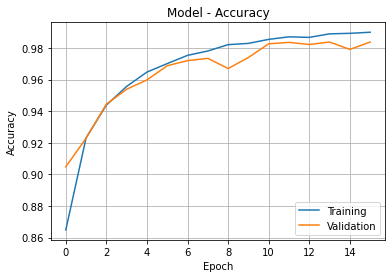

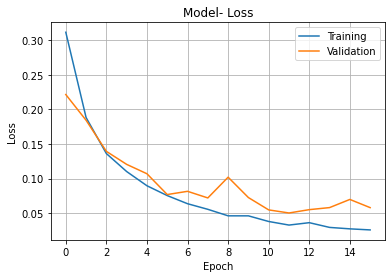

In [195]:
def evaluate_model(history):
    
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.grid()
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.grid()
    plt.show()

evaluate_model(history)    

- Dari hasil diatas kita bisa melihat jika akurasi training set = 0.99, sedangkan untuk akurasi validation set = 0.97
- Untuk plot loss training set = 0.01 sedangkan untuk loss validation set = 0.13

In [26]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5, 5))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

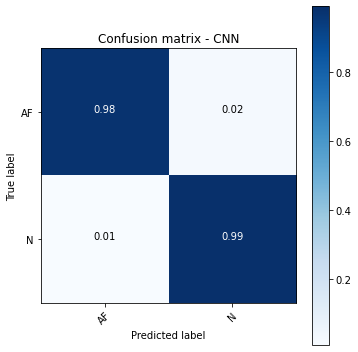

In [197]:
# predict test data
y_pred=model.predict(X_test)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=['AF', 'N'],normalize=True,
                      title='Confusion matrix - CNN')


- dari hasil plot confusion matrix, dapat dilihat tiap kelas memiliki banyak TRUE POSITIVE predicted data
- semakin gelap kebiruan menunjukan banyaknya hasil predicted label untuk true label tersebut

In [ ]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=['AF', 'N']))

- Jika kita lihat, nilai report untuk seluruh klas juga bagus, 
- Nilai recall dan precission juga tinggi, menunjukan model mampu memprediksi data dengan baik untuk seluruh data pada sclass tersebut 

___

## 2. Classification Deep Neural Network (DNN)

In [172]:
def dnn_model(max_len):
    
    model = Sequential()
    
    model.add(Dense(1024,
                    activation='relu',
                    input_shape=(max_len, )))
    model.add(Dropout(0.3))
    model.add(Dense(1024,
                    activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(512,
                    activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128,
                    activation='relu'))
    model.add(Dense(64,
                    activation='relu'))
    model.add(Dense(2,
                    activation='softmax'))
              
    model.summary()
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

In [173]:
def check_model(model_, x, y, x_val, y_val, epochs_, batch_size_):
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
                 ModelCheckpoint(filepath='dnn_best_model.h5', monitor='val_loss', save_best_only=True)]

    hist = model_.fit(x, 
                      y,
                      epochs=epochs_,
                      callbacks=callbacks, 
                      batch_size=batch_size_,
                      shuffle=True,
                      validation_data=(x_val,y_val))
                      #validation_split=0.15)
    #model_.load_weights('dnn_best_model.h5')
    return hist 

- reshape tensor

In [179]:
X_train = X_train.reshape(len(X_train), X_train.shape[1])
X_test = X_test.reshape(len(X_test), X_test.shape[1])

- run training

In [180]:
max_len = X_train.shape[1]  

EPOCHS = 50
BATCH_SIZE = 128

model = dnn_model(max_len)
history = check_model(model, X_train,y_train,X_test,y_test, EPOCHS, BATCH_SIZE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_194 (Dense)            (None, 1024)              308224    
_________________________________________________________________
dropout_39 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_195 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dropout_40 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_196 (Dense)            (None, 512)               524800    
_________________________________________________________________
dropout_41 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_197 (Dense)            (None, 128)               65664     
__________

- plot history

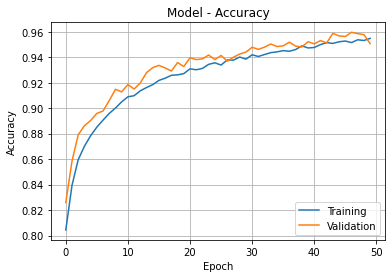

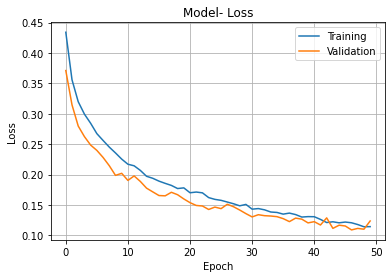

In [181]:
evaluate_model(history)

- save model

In [182]:
model.save("DNN_Classification_model.h5")

- save training history

In [183]:
pd.DataFrame.from_dict(history.history).to_csv('history_train_classif_dnn.csv',index=False)

- predict to all test dataset & plot confusion matrix

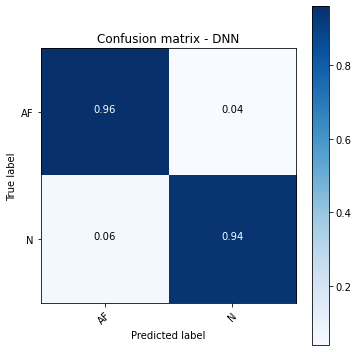

In [184]:
# predict test data
y_pred=model.predict(X_test)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=['AF', 'N'],normalize=True,
                      title='Confusion matrix - DNN')


- plot classification report

In [185]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=['AF', 'N']))

              precision    recall  f1-score   support

          AF       0.94      0.96      0.95      4445
           N       0.96      0.94      0.95      4555

    accuracy                           0.95      9000
   macro avg       0.95      0.95      0.95      9000
weighted avg       0.95      0.95      0.95      9000



___

## 3. Classification Recurrent Neural Network (RNN)

In [17]:
from keras.layers import LSTM, CuDNNLSTM, Bidirectional
from keras.optimizers import Adam, Adadelta

In [18]:
def rnn_model(max_len):
    opt = Adadelta()
    model = Sequential()
    
    model.add(Bidirectional(CuDNNLSTM(32,
                     return_sequences = True),
                     input_shape=(max_len, 1)))
    model.add(Bidirectional(CuDNNLSTM(32,
                      return_sequences = False)))
    model.add(Dense(64, 
                    activation='relu'))
    model.add(Dense(32, 
                    activation='relu'))
    model.add(Dense(2, 
                    activation='softmax'))
              
    model.summary()
    model.compile(optimizer=opt, 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

In [19]:
def check_model(model_, x, y, x_val, y_val, epochs_, batch_size_):
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
                 ModelCheckpoint(filepath='rnn_best_model.h5', monitor='val_loss', save_best_only=True)]

    hist = model_.fit(x, 
                      y,
                      epochs=epochs_,
                      callbacks=callbacks, 
                      batch_size=batch_size_,
                      shuffle=True,
                      validation_data=(x_val,y_val))
                      #validation_split=0.15)
    #model_.load_weights('rnn_best_model.h5')
    return hist 

- reshape tensor

In [20]:
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

- run training

In [21]:
max_len = X_train.shape[1]  

EPOCHS = 50
BATCH_SIZE = 32

model = rnn_model(max_len)
history=check_model(model, X_train,y_train,X_test,y_test, EPOCHS, BATCH_SIZE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 300, 64)           8960      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                25088     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 40,354
Trainable params: 40,354
Non-trainable params: 0
_________________________________________________________________
Train on 51000 samples, validate on 9000 samples
Epoch 1/50
51000/51000 [==============================] - 251s 5ms/step - loss: 0.5309 - 

- plot history

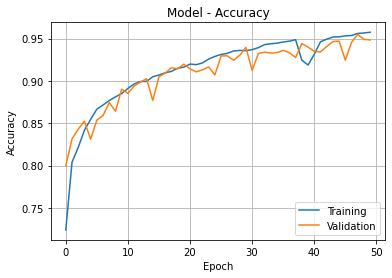

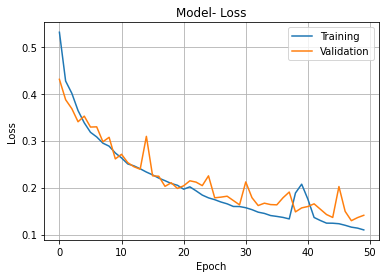

In [22]:
def evaluate_model(history):
    
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.grid()
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.grid()
    plt.show()

evaluate_model(history)

- Save model

In [23]:
model.save("RNN_Classification_model.h5")

- save training history

In [24]:
pd.DataFrame.from_dict(history.history).to_csv('history_train_classif_rnn.csv',index=False)

- predict to all test dataset & plot confusion matrix

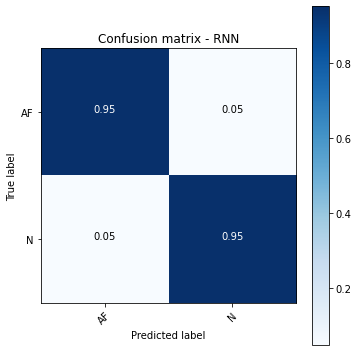

In [27]:
# predict test data
y_pred=model.predict(X_test)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=['AF', 'N'],normalize=True,
                      title='Confusion matrix - RNN')


- print calssification report

In [28]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=['AF', 'N']))

              precision    recall  f1-score   support

          AF       0.95      0.95      0.95      4445
           N       0.95      0.95      0.95      4555

    accuracy                           0.95      9000
   macro avg       0.95      0.95      0.95      9000
weighted avg       0.95      0.95      0.95      9000

